## Model description 

This model takes all words from the headlines in one day and extracts the sentiment as the elementwise addition of the word embeddings for that day. Each dimension of the embedding is then weighted and combined with an ARIMA-prediction of the value 'delay' days ahead.


In [1]:
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from nltk import word_tokenize
from pathlib import Path
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import gensim
import numpy as np
import pandas as pd 
import seaborn as sn
import os
import io
import pickle
import random
import itertools
from importnb import Notebook, reload
with Notebook(): 
    import Utilities

In [3]:
def preprocess_text(df):
    """ Tokenize """
    conc = pd.DataFrame()
    for i in set(df.index):
        concat_str = ''
        for title in df.loc[i]['title']:
            concat_str += " " + title.lower()
        concat_str = word_tokenize(concat_str)
        conc = conc.append({'date':i, 'title':concat_str},ignore_index=True)
    conc.set_index('date',inplace=True)
    conc = conc.sort_values('date')
    return conc

def title2vec(data, emb_dict,index): 
    """Embed a title with an arbitrary number of words to a vector 
     with shape(d), where d is the dimension of the embedding. """
    d = 300
    x = np.zeros((len(data), d))
    for i,row in enumerate(data.values): 
        n = 0
        temp = np.zeros(d)
        for word in row[0]: 
            if word in emb_dict.keys(): 
                n += 1
                temp = np.add(temp, emb_dict.get(word))
        x[i] = temp / n
    return x

In [4]:
config = {
    'start_date': '2006-10-20',
    'end_date': '2013-11-19',
    'lookback': 5,       # Using lookback > 1 is not yet implemented
    'delay': 3,
    'p': 1,
    'd': 1,
    'q': 1,
    'series': '1 YEAR',
}

In [5]:
# Load data
news_path = Path("../Datasets/data/financial_headlines_20061020-20131119.pkl")
news_data = pd.DataFrame(pd.read_pickle(news_path))
news_data.set_index('date',inplace=True)
# Tokenize
data = preprocess_text(news_data)

In [6]:
# Load dictionary of embeddings for this vocabulary (previously constructed)
subset_embeddings = Path("../Embeddings/GloVe/saved.42B.300d.pkl")
with open(subset_embeddings,'rb') as handle: 
    emb_dict = pickle.load(handle)

In [7]:
# Create an index mapping for all words in the vocabulary
word_index = {}
i = 1
for word in emb_dict.keys(): 
    word_index.update({word:i})
    i += 1

In [8]:
unique_words = set() 
for title in data['title']:
    for word in title: 
        unique_words.add(word)
print("Total vocabulary size:",len(unique_words))
print("Words not included in GloVe:",len(unique_words) - len(emb_dict))


Total vocabulary size: 29083
Words not included in GloVe: 2850


In [9]:
# Transform the data to the average word embedding each day
x = title2vec(data,emb_dict,word_index)

In [10]:
y = Utilities.load_binary_labels(config)

Loaded previously constructed labels.


In [11]:
# Need to remove some rows from the word embedding-matrix,
# these numbers are specified in Utilities.fit_all_models()
rm_start_rows = max(config['lookback'],5) + 1
rm_end_rows = config['delay']
x = x[rm_start_rows : -rm_end_rows]

In [12]:
(x_train,y_train), (x_test, y_test) = Utilities.shuffle_and_partition(x,y, test_part=0.2)

In [13]:
print("Shape of x_train: ",x_train.shape)
print("Shape of y_train: ",y_train.shape)

Shape of x_train:  (2056, 300)
Shape of y_train:  (2056,)


## Model construction 

We'll do a simple hyper parameter optimization including batch size, number of layers and numer of nodes per layer. 

In [ ]:
# Guessing all-zeroes, 
print("All zero test evaluation:",sum(y_test == 0) / len(y_test))

model = Sequential() 

model.add(Dense(40, activation='relu', input_shape=[x_train.shape[-1]]))
model.add(Dropout(0.3))
model.add(Dense(40,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

rms = optimizers.RMSprop(learning_rate=0.001)

model.compile(optimizer=rms, metrics=['acc'], loss='binary_crossentropy')

model.summary()

In [122]:
def create_nn(n_nodes, lr=0.001): 
    # n_nodes is a list with the number of nodes per layer, starting from the input 
    model = Sequential() 
    model.add(Dense(n_nodes[0], activation='relu', input_shape=[300]))
    if len(n_nodes) > 1: 
        for n in n_nodes: 
            model.add(Dense(n,activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    rms = optimizers.RMSprop(learning_rate=lr)
    model.compile(optimizer=rms, loss='binary_crossentropy', metrics=['acc'])
    return model

def train_and_format(x,y,bs,epochs, results, layers, nodes,lr):
    name = f"{bs}_{layers}_{nodes}"
    temp_history = model.fit(x, y, batch_size=bs, validation_split=0.2, epochs = epochs,verbose=0)
    return results.append(pd.Series([np.mean(temp_history.history['val_acc'][-5:]),
                                                temp_history, model, layers, 
                                                nodes, bs, lr], 
                                                name=name,
                                    index=['Mean Val Acc','History','Model','Layers','Nodes','Batch Size','Learning Rate']))


In [123]:
n_layers = [2]
n_nodes = [25, 50, 100, 200, 300, 400, 500]
learning_rates = [0.0001]
batch_sizes = [12]
epochs = 30
results = pd.DataFrame(columns=['Mean Val Acc','History','Model', 'Layers', 'Nodes','Batch Size','Learning Rate'])
n_configs = sum([len(n_nodes)**l for l in n_layers]) * len(batch_sizes) * len(learning_rates)
ctr = 0
print('Testing {} combinations. '.format(n_configs))
for layers in n_layers:
    if layers == 1: node_configs = list(itertools.product(n_nodes))
    elif layers == 2: node_configs = list(itertools.product(n_nodes, n_nodes))
    elif layers == 3: node_configs = list(itertools.product(n_nodes, n_nodes, n_nodes))
    elif layers == 4: node_configs = list(itertools.product(n_nodes, n_nodes, n_nodes, n_nodes))
    for bs in batch_sizes: 
        for temp_nodes in node_configs:
            for lr in learning_rates: 
                ctr += 1 
                model = create_nn(temp_nodes, lr)
                results = train_and_format(x_train, y_train, bs, epochs, results, layers, temp_nodes, lr)
                print("{} %     ".format(round(100 * ctr / n_configs,2)),end='\r')
            
            

Testing 49 combinations. 


In [178]:
k = 3
print("Top {} configs: ".format(k))
k_best = np.argpartition(results['Mean Val Acc'],-k)[-k:]
results.iloc[k_best]

Top 3 configs: 


,Mean Val Acc,History,Model,Layers,Nodes,Batch Size,Learning Rate
"12_2_(200, 50)",0.692718,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,2,"(200, 50)",12,0.0001
"12_2_(100, 400)",0.693204,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,2,"(100, 400)",12,0.0001
"12_2_(50, 500)",0.696602,<tensorflow.python.keras.callbacks.History obj...,<tensorflow.python.keras.engine.sequential.Seq...,2,"(50, 500)",12,0.0001


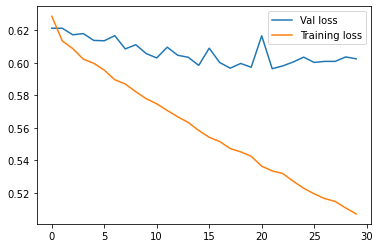

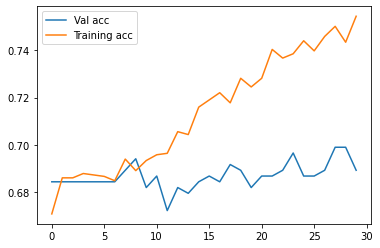

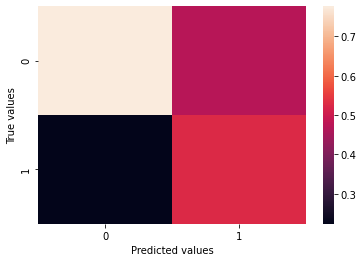

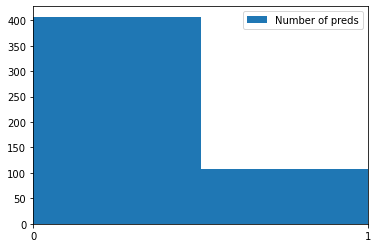

12_2_(200, 50)


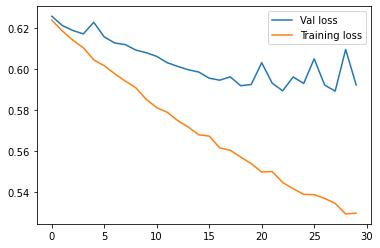

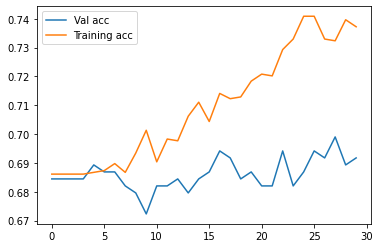

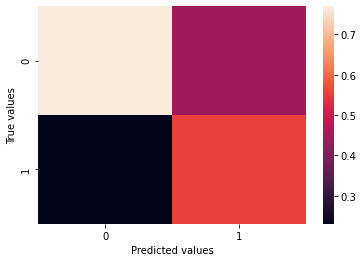

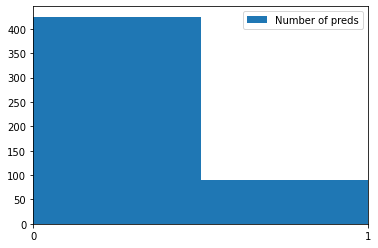

12_2_(100, 400)


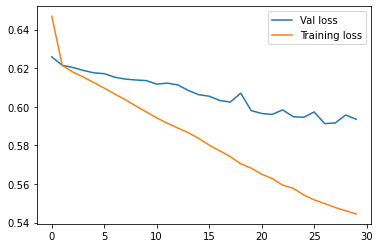

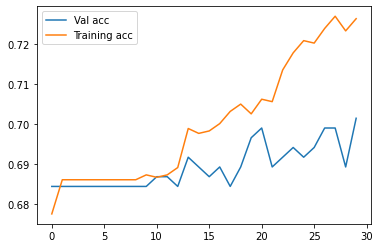

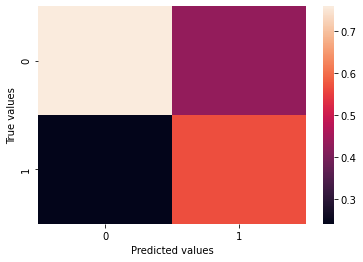

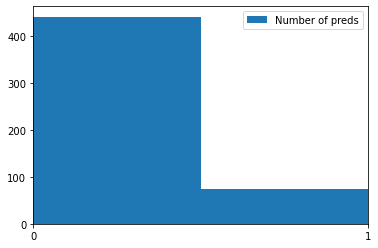

12_2_(50, 500)


In [173]:
for i in k_best: 
    plt.plot(results.iloc[i]['History'].history['val_loss'],label='Val loss')
    plt.plot(results.iloc[i]['History'].history['loss'],label='Training loss')
    plt.legend()
    plt.show()
    plt.plot(results.iloc[i]['History'].history['val_acc'],label='Val acc')
    plt.plot(results.iloc[i]['History'].history['acc'],label='Training acc')
    plt.legend()
    plt.show()
    model = results.iloc[i]['Model']
    model.evaluate(x_test,y_test,verbose=0)
    y_test_pred = np.round(model.predict(x_test))
    conf_mat = confusion_matrix(y_test,y_test_pred,normalize='pred')
    ax = sn.heatmap(conf_mat,)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    plt.show()
    fig,ax = plt.subplots() 
    ax.hist(y_test_pred,2,align='mid',label='Number of preds')
    ax.set(xticks=range(2), xlim=[0, 1])
    plt.legend()
    plt.show()
    print(results.index[i])
